In [ ]:
!pip install gtsam

In [1]:
from __future__ import print_function

import math
import unittest
from functools import reduce

import matplotlib.pyplot as plt
import numpy as np
import scipy
from scipy import linalg, matrix

from sympy import Matrix
from mpl_toolkits.mplot3d import Axes3D  # pylint: disable=W0611

import matplotlib.patches as mpatches
import matplotlib.transforms as mtransforms
import mpl_toolkits.mplot3d.axes3d as p3

# Required to do animations in colab
from matplotlib import animation
from IPython.display import HTML
from mobileManipulator import FourLinkMM
import gtsam
import gtsam.utils.plot as gtsam_plot
from gtsam import Pose2
import shapely
from shapely.geometry import Polygon
from shapely import affinity
from utils import *

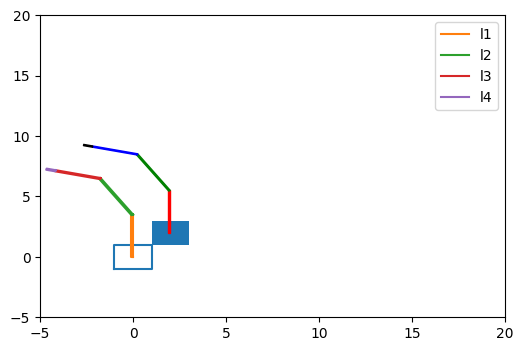

In [3]:
fig = plt.figure()
fig.set_dpi(100)
ax = plt.axes(xlim=(-5, 20), ylim=(-5, 20))
plt.rc('animation', html='jshtml') # needed for animations!
#ax = plt.axes()
#plt.close()
N= 25
size=10.5
len_b = 2
d = np.sqrt(2*len_b*len_b/4)
omega = 2*math.pi/N
arm = FourLinkMM()
arm.x_b = 2
arm.y_b = 2
q = np.radians(vector4(90,30,45,0))
sTt_initial = arm.fwd_kinematics(q)
sTt_goal = Pose2(5.75, 1.75, math.radians(0))
poses = trajectory(sTt_initial, sTt_goal, N)
rect = mpatches.Rectangle([arm.x_b-d*np.cos(arm.theta_b+np.radians(45)),arm.y_b-d*np.sin(arm.theta_b+np.radians(45))],
         len_b, len_b, angle = arm.theta_b*180/np.pi)

sXl1 = Pose2(0, 0, arm.theta_b)
l1Zl1 = Pose2(0, 0, q[0])
l1Xl2 = Pose2(arm.L1, 0, 0)
sTl2 = compose(sXl1, l1Zl1, l1Xl2)
t1 = sTl2.translation()
# print(t1)

l2Zl2 = Pose2(0, 0, q[1])
l2Xl3 = Pose2(arm.L2, 0, 0)
sTl3 = compose(sTl2, l2Zl2, l2Xl3)
t2 = sTl3.translation()
# print(t2)

l3Zl3 = Pose2(0, 0, q[2])
l3X4 = Pose2(arm.L3, 0, 0)
sTl4 = compose(sTl3, l3Zl3, l3X4)
t3 = sTl4.translation()
# print(t3)

l4Zl4 = Pose2(0, 0, q[3])
l4Xt = Pose2(arm.L4, 0, 0)
sTt = compose(sTl4, l4Zl4, l4Xt)
t4 = sTt.translation()
# print(t4)
link_1 = mpatches.Rectangle([arm.x_b,arm.y_b], 3.5, 0.1, angle =(arm.theta_b+q[0])*180/np.pi, color='r')
link_2 = mpatches.Rectangle([t1.x()+arm.x_b,t1.y()+arm.y_b], 3.5, 0.1, angle =(arm.theta_b+q[0]+q[1])*180/np.pi, color='g')
link_3 = mpatches.Rectangle([t2.x() + arm.x_b, t2.y() + arm.y_b], 2.5, 0.1, angle =(arm.theta_b + q[0]+q[1]+q[2])*180/np.pi, color='b')
link_4 = mpatches.Rectangle([t3.x()+ arm.x_b , t3.y() + arm.y_b], 0.5, 0.1, angle =(arm.theta_b+q[0]+q[1]+q[2]+q[3])*180/np.pi, color='k')
ax.add_patch(rect)
ax.add_patch(link_1)
ax.add_patch(link_2)
ax.add_patch(link_3)
ax.add_patch(link_4)
arm.update_manipulator_model(Pose2(0, 0, 0), q)
arm_model = arm.arm_model
# print(arm_model['L1'].exterior.xy)
ax.plot(*arm.base_model.exterior.xy)
ax.plot(*arm_model['L1'].exterior.xy, label='l1')
ax.plot(*arm_model['L2'].exterior.xy, label='l2')
ax.plot(*arm_model['L3'].exterior.xy, label='l3')
ax.plot(*arm_model['L4'].exterior.xy, label='l4')
ax.legend()

In [4]:
def init():

  # For animation
    rect = mpatches.Rectangle([arm.x_b-d*np.cos(arm.theta_b+np.radians(45)),arm.y_b-d*np.sin(arm.theta_b+np.radians(45))], len_b, len_b, angle = arm.theta_b*180/np.pi)
#     ax.add_patch(rect)
#     ax.add_patch(link_1)
#     ax.add_patch(link_2)
#     ax.add_patch(link_3)
#     ax.add_patch(link_4)
#     ax.add_patch(mpatches.FancyArrow(arm.x_b,arm.y_b, 1.5*np.cos(arm.theta_b), 1.5*np.sin(arm.theta_b), color='r',head_width = 0.3))

    return rect, link_1, link_2, link_3, link_4,

def animate(i):

    global poses
    global arm
    global q
    # Computes the forward kinematics to get the pose of the end-effector for the given angular position of the joints (q)
    q = arm.ik(poses[i])
    sTt = arm.fwd_kinematics(q)
    # Evaluate the error between the current position of the end-effector and the desired position at moment i
    error_vector = delta(sTt, poses[i])
    error = np.linalg.norm(error_vector)

    # Get the jacobian of the arm at the given pose
    J = arm.manipulator_jacobian(q)
    # Move the arm joints in the respective direction
    # q += np.dot(np.linalg.pinv(J), error)
    # q = np.remainder(q+math.pi, 2*math.pi)-math.pi
    # ------------------------- ANIMATION ----------------------------------------------------
    rect = mpatches.Rectangle([arm.x_b-d*np.cos(arm.theta_b+np.radians(45)),arm.y_b-d*np.sin(arm.theta_b+np.radians(45))],
                    len_b, len_b, angle = arm.theta_b*180/np.pi, color = 'r', alpha=0.4)
    #ax.clear()
    #rect.set_xy((arm.x_b-d*np.cos(arm.theta_b+np.radians(45)), arm.y_b-d*np.sin(arm.theta_b+np.radians(45))))
    #rect._angle = arm.theta_b*180/np.pi
    ax.clear()
    ax.set_xlim((-size, size))
    ax.set_ylim((-size, size))
    ax.add_patch(rect)
    sXl1 = Pose2(0, 0, arm.theta_b)
    l1Zl1 = Pose2(0, 0, q[0])
    l1Xl2 = Pose2(arm.L1, 0, 0)
    sTl2 = compose(sXl1, l1Zl1, l1Xl2)
    t1 = sTl2.translation()
    # link_1 = mpatches.Rectangle([arm.x_b,arm.y_b], 3.5, 0.1, angle =(arm.theta_b+q[0])*180/np.pi+90, color='r')
#     link_1.set_xy([arm.x_b, arm.y_b])
#     link_1._angle = np.rad2deg(arm.theta_b+q[0])
    # print(link_1._angle)

    ax.add_artist(mpatches.Rectangle([arm.x_b,arm.y_b], 3.5, 0.1, angle =np.rad2deg(arm.theta_b+q[0]), color='r'))
#     ax.add_artist(mpatches.FancyArrow(MM.x_b,MM.y_b, 1.5*np.cos(MM.theta_b), 1.5*np.sin(MM.theta_b), color='r',head_width = 0.3))

    l2Zl2 = Pose2(0, 0, q[1])
    l2Xl3 = Pose2(arm.L2, 0, 0)
    sTl3 = compose(sTl2, l2Zl2, l2Xl3)
    t2 = sTl3.translation()
#     link_2.set_xy([t1.x()+arm.x_b, t1.y() + arm.y_b])
#     link_2._angle = np.rad2deg(arm.theta_b+q[0]+q[1])
    ax.add_artist(mpatches.Rectangle([t1.x()+arm.x_b,t1.y()+arm.y_b], 3.5, 0.1, angle =np.rad2deg(arm.theta_b+q[0]+q[1]), color='g'))

    l3Zl3 = Pose2(0, 0, q[2])
    l3X4 = Pose2(arm.L3, 0, 0)
    sTl4 = compose(sTl3, l3Zl3, l3X4)
    t3 = sTl4.translation()
#     link_3.set_xy([t2.x()+arm.x_b,t2.y()+arm.y_b])
#     link_3._angle = np.rad2deg(arm.theta_b+q[0]+q[1]+q[2])
    ax.add_artist(mpatches.Rectangle([t2.x()+arm.x_b,t2.y()+arm.y_b], 2.5, 0.1, angle = np.rad2deg(arm.theta_b+q[0]+q[1]+q[2]), color='b'))

    l4Zl4 = Pose2(0, 0, q[3])
    l4Xt = Pose2(arm.L4, 0, 0)
    sTt = compose(sTl4, l4Zl4, l4Xt)
    t4 = sTt.translation()
#     link_4.set_xy([t3.x()+arm.x_b,t3.y()+arm.y_b])
#     link_4._angle = np.rad2deg(arm.theta_b+q[0]+q[1]+q[2]+q[3])
    ax.add_artist(mpatches.Rectangle([t3.x()+arm.x_b,t3.y()+arm.y_b], 0.5, 0.1, angle =np.rad2deg(arm.theta_b+q[0]+q[1]+q[2]+q[3]), color='k'))


    return rect, 

In [5]:
animation.FuncAnimation(fig, animate, init_func=init,
                        frames=N, interval=1000, blit=False)
# plt.show()